# Geodesic Plots

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from geodesics import GradientDescent, JAXOptimization, ScipyOptimization, GEORCE
from manifolds import nSphere, nEuclidean, nParaboloid, HyperbolicParaboloid

2024-06-06 15:06:19.827264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

## Hyper-Parameters

In [3]:
tol = 1e-4
max_iter = 1000
T = 100
line_search_iter = 100

### Gradient Descent

In [4]:
grad_decay = 0.90
grad_lr_rate = 1.0

### JAX Optimization

In [5]:
jax_lr_rate = 0.01

### Geodesic Control

In [6]:
gc_decay = 0.9
gc_lr_rate = 1.0

## Geodesic Computations on $\mathbb{S}^{2}$

### Plotting

In [7]:
M = nSphere(dim=2)

In [8]:
#x0 = jnp.array([jnp.cos(5*jnp.pi/4),jnp.sin(5*jnp.pi/4),0.8])
#xT = jnp.array([jnp.cos(0.0),jnp.sin(0.0),0.8])

#x0 /= jnp.linalg.norm(x0)
#xT /= jnp.linalg.norm(xT)

#z0 = M.invF(x0)
#zT = M.invF(xT)

In [9]:
s2_z0 = -jnp.linspace(0,1,2)
s2_zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = M.F(s2_z0)
s2_xT = M.F(s2_zT)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [10]:
class SpherePlot(ABC):
    def __init__(self, seed=2712):
        
        self.seed = 2712
        self.rng_key = jrandom.PRNGKey(seed)

    def sphere_grid(self, n_points:int=100):
        self.rng_key, subkey = jrandom.split(self.rng_key)
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return x1,x2,x3
         

In [11]:
plot_sphere = SpherePlot()

### Ground Truth

In [12]:
s2_xt_true = M.Geodesic(s2_z0,s2_zT)
s2_true_dist = M.dist(s2_z0,s2_zT)

### Gradient Descent

In [13]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [14]:
zt = Geodesic.init_fun(s2_z0,s2_zT,T)
s2_xt_init = jnp.vstack((s2_x0, vmap(lambda z: M.F(z))(zt), s2_xT))
s2_init_length = M.length(zt)

In [17]:
zt, grad, s2_grad_idx = Geodesic(s2_z0,s2_zT)

In [18]:
s2_xt_grad = vmap(lambda z: M.F(z))(zt)
s2_grad_length = M.length(zt)

### JAX Optimization

In [19]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [25]:
zt, grad, s2_jax_idx = Geodesic(s2_z0,s2_zT, "while")

In [26]:
s2_xt_jax = vmap(lambda z: M.F(z))(zt)
s2_jax_length = M.length(zt)

### Scipy Optimization

In [27]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [32]:
zt, grad, s2_scipy_idx = Geodesic(s2_z0,s2_zT, "while")

In [33]:
s2_xt_scipy = vmap(lambda z: M.F(z))(zt)
s2_scipy_length = M.length(zt)

### Geodesic Control

In [34]:
Geodesic = GEORCE(M=M,
                  init_fun=None,
                  lr_rate=gc_lr_rate,
                  T=T,
                  decay_rate=0.5,
                  tol=tol,
                  max_iter=max_iter,
                  line_search_iter=line_search_iter
                 )

In [36]:
zt, grad, s2_gc_idx = Geodesic(s2_z0,s2_zT, "while")

In [25]:
s2_xt_gc = vmap(lambda z: M.F(z))(zt)
s2_gc_length = M.length(zt)

### Plotting

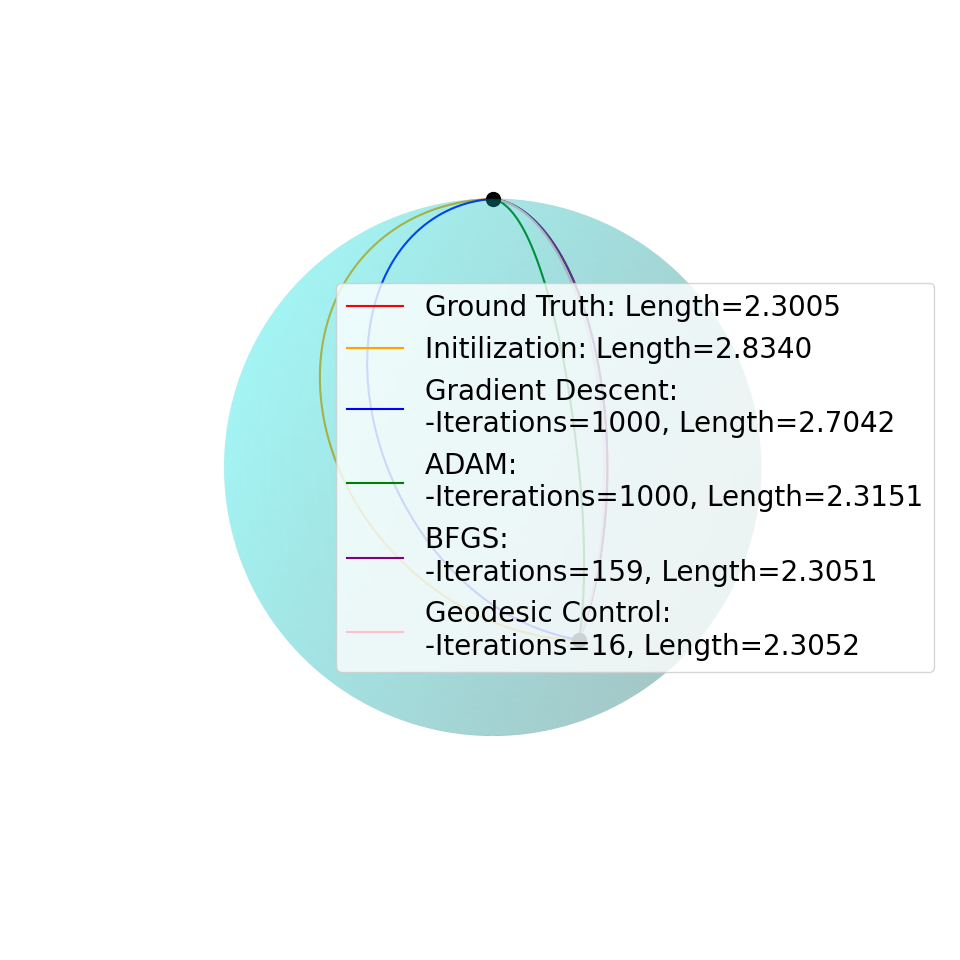

In [26]:
x1,x2,x3 = plot_sphere.sphere_grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.plot(s2_xt_true[:,0], s2_xt_true[:,1], s2_xt_true[:,2], color='red', alpha=1.0,
       label=f"Ground Truth: Length={s2_true_dist:.4f}")
ax.plot(s2_xt_init[:,0], s2_xt_init[:,1], s2_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={s2_init_length:.4f}")
ax.plot(s2_xt_grad[:,0], s2_xt_grad[:,1], s2_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={s2_grad_idx}, Length={s2_grad_length:.4f}")
ax.plot(s2_xt_jax[:,0], s2_xt_jax[:,1], s2_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Itererations={s2_jax_idx}, Length={s2_jax_length:.4f}")
ax.plot(s2_xt_scipy[:,0], s2_xt_scipy[:,1], s2_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={s2_scipy_idx}, Length={s2_scipy_length:.4f}")
ax.plot(s2_xt_gc[:,0], s2_xt_gc[:,1], s2_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={s2_gc_idx}, Length={s2_gc_length:.4f}")
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.3), ncol=1)

plt.show()


## Geodesic Computations on Paraboloid

### Plotting

In [147]:
M = nParaboloid(dim=2)

In [148]:
#r = 1.0
#p2_z0 = r*jnp.array([jnp.cos(-5*jnp.pi/4), jnp.sin(-5*jnp.pi/4)])
#p2_zT = r*jnp.array([jnp.cos(0.0),jnp.sin(0.0)])

#x0 = M.F(z0)
#xT = M.F(zT)

In [149]:
p_z0 = -jnp.linspace(0,1,2)
p_zT = jnp.ones(2)

p_x0 = M.F(p_z0)
p_xT = M.F(p_zT)

In [150]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2
         

In [151]:
plot_paraboloid = ParaboloidPlot()

### Gradient Descent

In [152]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [153]:
zt = Geodesic.init_fun(p_z0,p_zT,T)
p_xt_init = jnp.vstack((p_x0, vmap(lambda z: M.F(z))(zt), p_xT))
p_init_length = M.length(p_xt_init)

In [154]:
zt, grad, p_grad_idx = Geodesic(p_z0,p_zT)

In [155]:
p_xt_grad = vmap(lambda z: M.F(z))(zt)
p_grad_length = M.length(zt)

### JAX Optimization

In [156]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [157]:
zt, grad, p_jax_idx = Geodesic(p_z0,p_zT)

In [158]:
p_xt_jax = vmap(lambda z: M.F(z))(zt)
p_jax_length = M.length(zt)

### Scipy Optimization

In [159]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [160]:
zt, grad, p_scipy_idx = Geodesic(p_z0,p_zT)

In [161]:
p_xt_scipy = vmap(lambda z: M.F(z))(zt)
p_scipy_length = M.length(zt)

### Geodesic Control

In [162]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=0.5,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [163]:
zt, grad, p_gc_idx = Geodesic(p_z0,p_zT)

In [164]:
p_xt_gc = vmap(lambda z: M.F(z))(zt)
p_gc_length = M.length(zt)

### Plotting

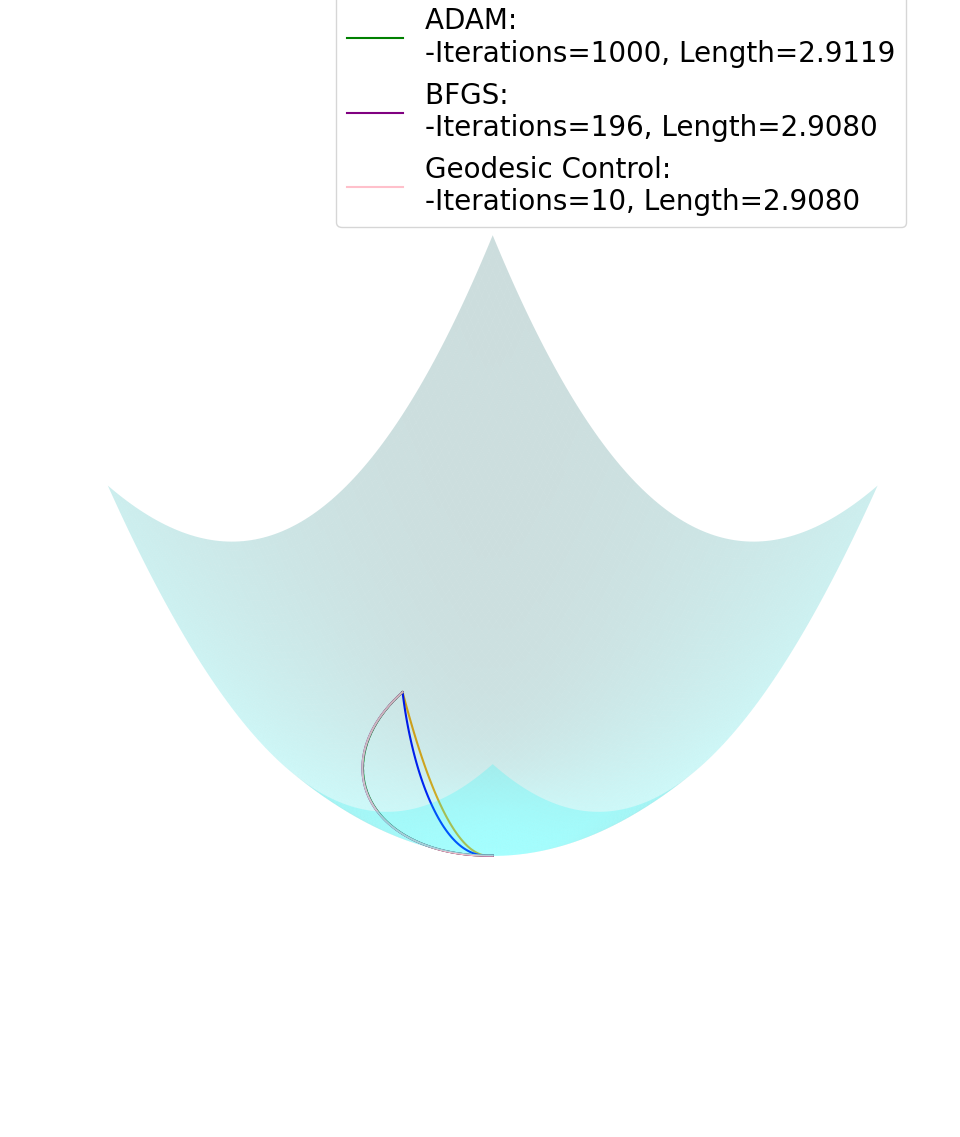

In [165]:
x1,x2,x3 = ParaboloidPlot.grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(p_xt_init[:,0], p_xt_init[:,1], p_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={p_init_length:.4f}")
ax.plot(p_xt_grad[:,0], p_xt_grad[:,1], p_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={p_grad_idx}, Length={p_grad_length:.4f}")
ax.plot(p_xt_jax[:,0], p_xt_jax[:,1], p_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={p_jax_idx}, Length={p_jax_length:.4f}")
ax.plot(p_xt_scipy[:,0], p_xt_scipy[:,1], p_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={p_scipy_idx}, Length={p_scipy_length:.4f}")
ax.plot(p_xt_gc[:,0], p_xt_gc[:,1], p_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={p_gc_idx}, Length={p_gc_length:.4f}")
ax.set_axis_off()
ax.view_init(elev=45., azim=45.)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.8), ncol=1)

plt.show()


## Geodesic Computations on Hyperbolic Paraboloid

### Plotting

In [166]:
M = HyperbolicParaboloid()

In [167]:
r = 1.0
hp_z0 = r*jnp.array([-3.,-3.])
hp_zT = r*jnp.array([3.,-3.])

hp_x0 = M.F(hp_z0)
hp_xT = M.F(hp_zT)

In [168]:
class HyperbolicParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-5.0, 5.0, n_points)
        x2 = jnp.linspace(-5.0, 5.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2-X2**2
         

In [169]:
plot_hyperbolicparaboloid = HyperbolicParaboloidPlot()

### Gradient Descent

In [170]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [171]:
zt = Geodesic.init_fun(hp_z0,hp_zT,T)
hp_xt_init = jnp.vstack((hp_x0, vmap(lambda z: M.F(z))(zt), hp_xT))
hp_init_length = M.length(zt)

In [172]:
zt, grad, hp_grad_idx = Geodesic(hp_z0,hp_zT)

In [173]:
hp_xt_grad = vmap(lambda z: M.F(z))(zt)
hp_grad_length = M.length(zt)

### JAX Optimization

In [174]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [175]:
zt, grad, hp_jax_idx = Geodesic(hp_z0,hp_zT)

In [176]:
hp_xt_jax = vmap(lambda z: M.F(z))(zt)
hp_jax_length = M.length(zt)

### Scipy Optimization

In [177]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [178]:
zt, grad, hp_scipy_idx = Geodesic(hp_z0,hp_zT)

In [179]:
hp_xt_scipy = vmap(lambda z: M.F(z))(zt)
hp_scipy_length = M.length(zt)

### Geodesic Control

In [180]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=0.9,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [181]:
zt, grad, hp_gc_idx = Geodesic(hp_z0,hp_zT)

In [182]:
hp_xt_gc = vmap(lambda z: M.F(z))(zt)
hp_gc_length = M.length(hp_xt_gc)

### Plotting

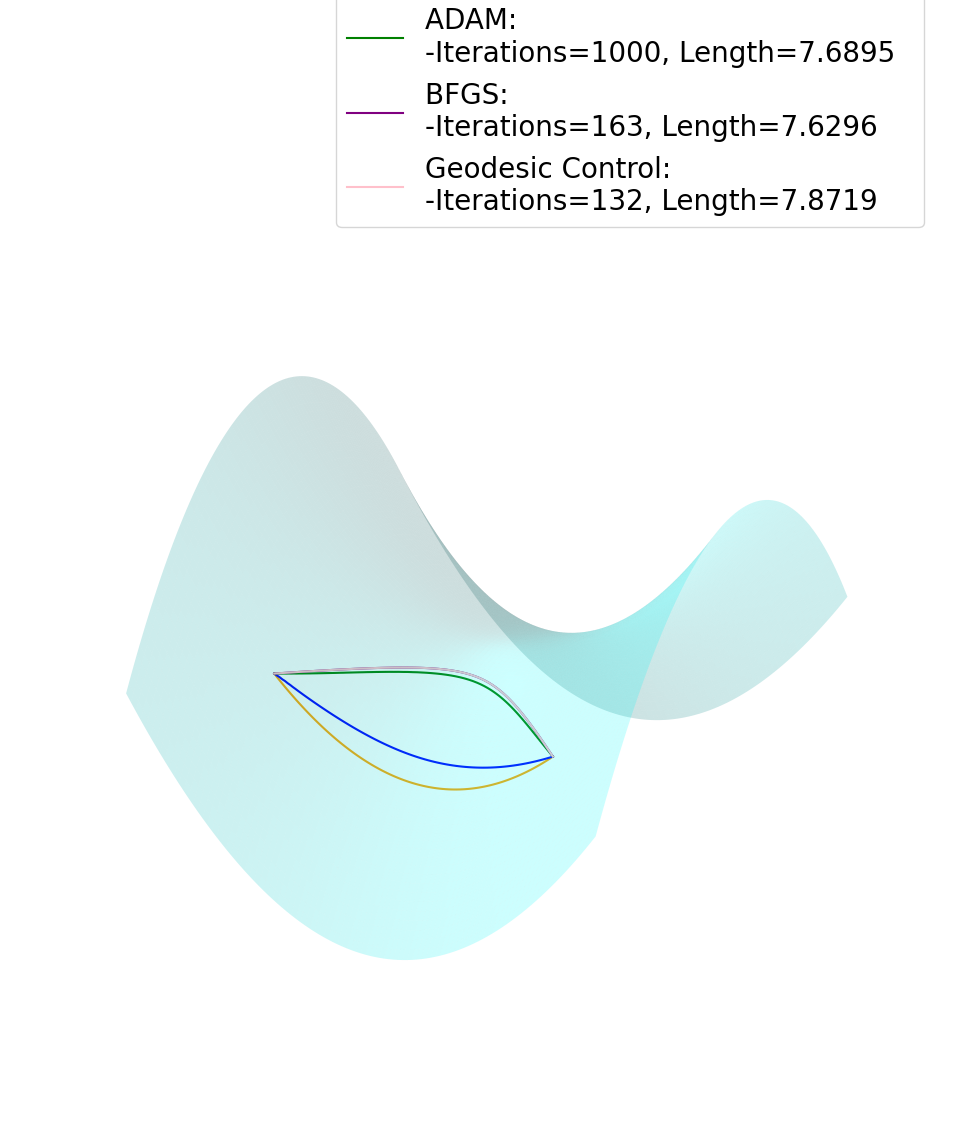

In [183]:
x1,x2,x3 = HyperbolicParaboloidPlot.grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(hp_xt_init[:,0], hp_xt_init[:,1], hp_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={hp_init_length:.4f}")
ax.plot(hp_xt_grad[:,0], hp_xt_grad[:,1], hp_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={hp_grad_idx}, Length={hp_grad_length:.4f}")
ax.plot(hp_xt_jax[:,0], hp_xt_jax[:,1], hp_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={hp_jax_idx}, Length={hp_jax_length:.4f}")
ax.plot(hp_xt_scipy[:,0], hp_xt_scipy[:,1], hp_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={hp_scipy_idx}, Length={hp_scipy_length:.4f}")
ax.plot(hp_xt_gc[:,0], hp_xt_gc[:,1], hp_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={hp_gc_idx}, Length={hp_gc_length:.4f}")
ax.set_axis_off()
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.8), ncol=1)

plt.show()


## Plotting

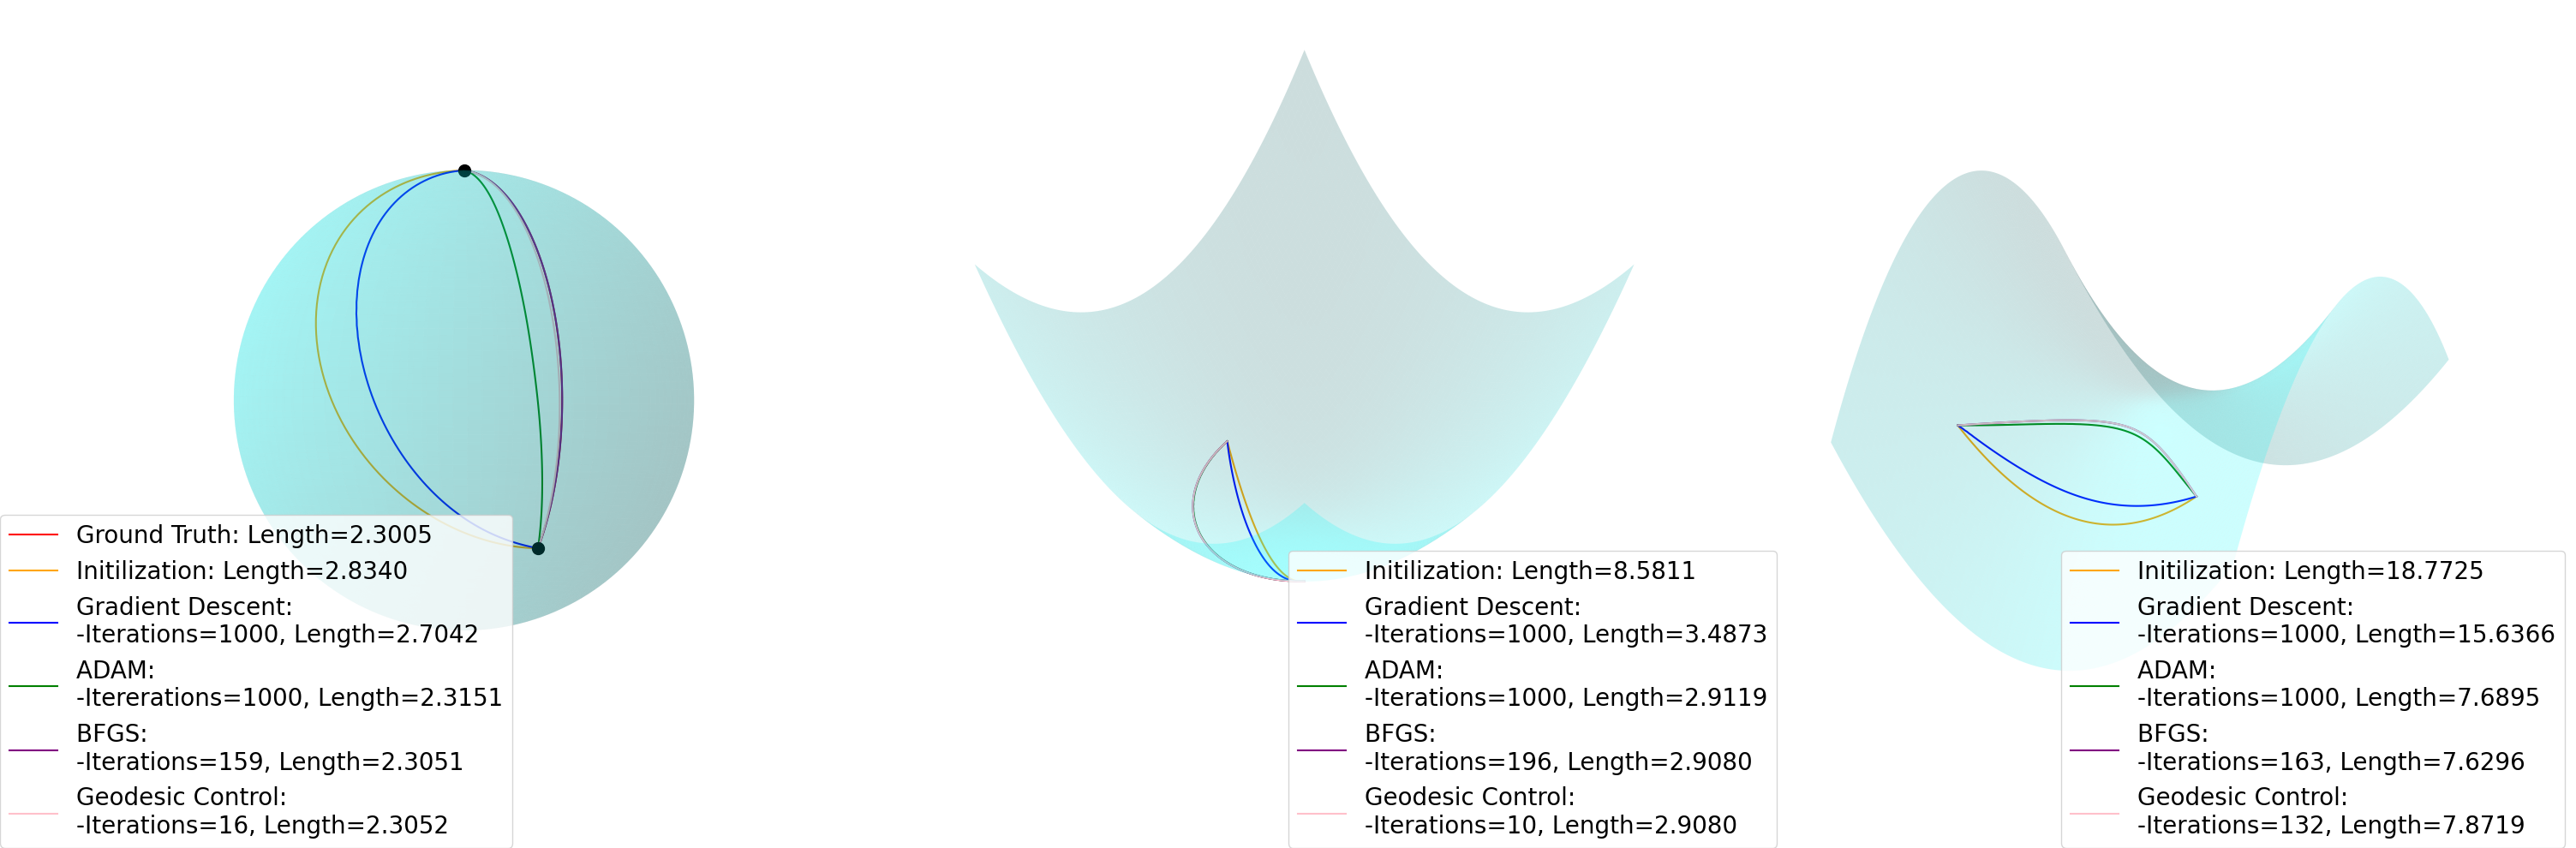

In [184]:
fig = plt.figure(figsize=(30,10))

x1,x2,x3 = plot_sphere.sphere_grid(100)
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.plot(s2_xt_true[:,0], s2_xt_true[:,1], s2_xt_true[:,2], color='red', alpha=1.0,
       label=f"Ground Truth: Length={s2_true_dist:.4f}")
ax.plot(s2_xt_init[:,0], s2_xt_init[:,1], s2_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={s2_init_length:.4f}")
ax.plot(s2_xt_grad[:,0], s2_xt_grad[:,1], s2_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={s2_grad_idx}, Length={s2_grad_length:.4f}")
ax.plot(s2_xt_jax[:,0], s2_xt_jax[:,1], s2_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Itererations={s2_jax_idx}, Length={s2_jax_length:.4f}")
ax.plot(s2_xt_scipy[:,0], s2_xt_scipy[:,1], s2_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={s2_scipy_idx}, Length={s2_scipy_length:.4f}")
ax.plot(s2_xt_gc[:,0], s2_xt_gc[:,1], s2_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={s2_gc_idx}, Length={s2_gc_length:.4f}")
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.0,0.0), ncol=1)

x1,x2,x3 = ParaboloidPlot.grid(100)
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(p_xt_init[:,0], p_xt_init[:,1], p_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={p_init_length:.4f}")
ax.plot(p_xt_grad[:,0], p_xt_grad[:,1], p_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={p_grad_idx}, Length={p_grad_length:.4f}")
ax.plot(p_xt_jax[:,0], p_xt_jax[:,1], p_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={p_jax_idx}, Length={p_jax_length:.4f}")
ax.plot(p_xt_scipy[:,0], p_xt_scipy[:,1], p_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={p_scipy_idx}, Length={p_scipy_length:.4f}")
ax.plot(p_xt_gc[:,0], p_xt_gc[:,1], p_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={p_gc_idx}, Length={p_gc_length:.4f}")
ax.set_axis_off()
ax.view_init(elev=45., azim=45.)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.5,0.0), ncol=1)

x1,x2,x3 = HyperbolicParaboloidPlot.grid(100)
ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(hp_xt_init[:,0], hp_xt_init[:,1], hp_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={hp_init_length:.4f}")
ax.plot(hp_xt_grad[:,0], hp_xt_grad[:,1], hp_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={hp_grad_idx}, Length={hp_grad_length:.4f}")
ax.plot(hp_xt_jax[:,0], hp_xt_jax[:,1], hp_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={hp_jax_idx}, Length={hp_jax_length:.4f}")
ax.plot(hp_xt_scipy[:,0], hp_xt_scipy[:,1], hp_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={hp_scipy_idx}, Length={hp_scipy_length:.4f}")
ax.plot(hp_xt_gc[:,0], hp_xt_gc[:,1], hp_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={hp_gc_idx}, Length={hp_gc_length:.4f}")
ax.set_axis_off()
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.8,0.0), ncol=1)

plt.show()



## Geodesic Computations on $\mathbb{S}^{2}$

### Plotting

In [65]:
M = nSphere(dim=2)

In [66]:
#x0 = jnp.array([jnp.cos(5*jnp.pi/4),jnp.sin(5*jnp.pi/4),0.8])
#xT = jnp.array([jnp.cos(0.0),jnp.sin(0.0),0.8])

#x0 /= jnp.linalg.norm(x0)
#xT /= jnp.linalg.norm(xT)

#z0 = M.invF(x0)
#zT = M.invF(xT)

In [67]:
s2_z0 = -jnp.linspace(0,1,2)
s2_zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = M.F(s2_z0)
s2_xT = M.F(s2_zT)

In [68]:
class SpherePlot(ABC):
    def __init__(self, seed=2712):
        
        self.seed = 2712
        self.rng_key = jrandom.PRNGKey(seed)

    def sphere_grid(self, n_points:int=100):
        self.rng_key, subkey = jrandom.split(self.rng_key)
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return x1,x2,x3
         

In [69]:
plot_sphere = SpherePlot()

### Ground Truth

In [70]:
s2_xt_true = M.Geodesic(s2_z0,s2_zT)
s2_true_dist = M.dist(s2_z0,s2_zT)

### Geodesic Control

In [71]:
Geodesic = GC_LineSearch_for(M=M,
                             init_fun=None,
                             lr_rate=gc_lr_rate,
                             T=T,
                             decay_rate=0.5,
                             max_iter=max_iter,
                             line_search_iter=line_search_iter
                            )

In [72]:
zt = Geodesic(s2_z0,s2_zT)

In [73]:
base_curve = zt[-1]

In [74]:
s2_gc_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
s2_gc_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

### Gradient Descent

In [75]:
Geodesic = GradientDescent_for(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           line_search_iter=line_search_iter
                          )

In [76]:
zt = Geodesic(s2_z0,s2_zT)

In [77]:
s2_grad_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
s2_grad_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

### JAX Optimization

In [78]:
Geodesic = JAXOptimization_for(M = M,
                              init_fun=None,
                              lr_rate=jax_lr_rate,
                              optimizer=None,
                              T=T,
                              max_iter=max_iter
                              )

In [79]:
zt = Geodesic(s2_z0,s2_zT)

In [80]:
s2_jax_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
s2_jax_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

### Scipy Optimization

In [81]:
Geodesic = ScipyOptimization_for(M = M,
                             T=T,
                             tol=None,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [82]:
zt = Geodesic(s2_z0,s2_zT)

In [83]:
s2_scipy_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
s2_scipy_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

## Geodesic Computations on Paraboloid

### Plotting

In [84]:
M = nParaboloid(dim=2)

In [85]:
#r = 1.0
#p2_z0 = r*jnp.array([jnp.cos(-5*jnp.pi/4), jnp.sin(-5*jnp.pi/4)])
#p2_zT = r*jnp.array([jnp.cos(0.0),jnp.sin(0.0)])

#x0 = M.F(z0)
#xT = M.F(zT)

In [86]:
p_z0 = -jnp.linspace(0,1,2)
p_zT = jnp.ones(2)

p_x0 = M.F(p_z0)
p_xT = M.F(p_zT)

In [87]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2
         

In [88]:
plot_paraboloid = ParaboloidPlot()

### Geodesic Control

In [89]:
Geodesic = GC_LineSearch_for(M=M,
                             init_fun=None,
                             lr_rate=gc_lr_rate,
                             T=T,
                             decay_rate=0.5,
                             max_iter=max_iter,
                             line_search_iter=line_search_iter
                            )

In [90]:
zt = Geodesic(p_z0,p_zT)

In [91]:
base_curve = zt[-1]

In [92]:
p_gc_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
p_gc_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

### Gradient Descent

In [93]:
Geodesic = GradientDescent_for(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           line_search_iter=line_search_iter
                          )

In [94]:
zt = Geodesic(p_z0,p_zT)

In [95]:
p_grad_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
p_grad_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

### JAX Optimization

In [96]:
Geodesic = JAXOptimization_for(M = M,
                              init_fun=None,
                              lr_rate=jax_lr_rate,
                              optimizer=None,
                              T=T,
                              max_iter=max_iter
                              )

In [97]:
zt = Geodesic(p_z0,p_zT)

In [98]:
p_jax_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
p_jax_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

### Scipy Optimization

In [99]:
Geodesic = ScipyOptimization_for(M = M,
                             T=T,
                             tol=None,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [100]:
zt = Geodesic(p_z0,p_zT)

In [101]:
p_scipy_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
p_scipy_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

## Geodesic Computations on Hyperbolic Paraboloid

### Plotting

In [102]:
M = HyperbolicParaboloid()

In [103]:
r = 1.0
hp_z0 = r*jnp.array([-3.,-3.])
hp_zT = r*jnp.array([3.,-3.])

hp_x0 = M.F(hp_z0)
hp_xT = M.F(hp_zT)

In [104]:
class HyperbolicParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-5.0, 5.0, n_points)
        x2 = jnp.linspace(-5.0, 5.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2-X2**2
         

In [105]:
plot_hyperbolicparaboloid = HyperbolicParaboloidPlot()

### Geodesic Control

In [106]:
Geodesic = GC_LineSearch_for(M=M,
                             init_fun=None,
                             lr_rate=gc_lr_rate,
                             T=T,
                             decay_rate=0.5,
                             max_iter=max_iter,
                             line_search_iter=line_search_iter
                            )

In [107]:
zt = Geodesic(hp_z0,hp_zT)

In [108]:
base_curve = zt[-1]

In [109]:
hp_gc_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
hp_gc_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

### Gradient Descent

In [110]:
Geodesic = GradientDescent_for(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           line_search_iter=line_search_iter
                          )

In [111]:
zt = Geodesic(hp_z0,hp_zT)

In [112]:
hp_grad_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
hp_grad_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

### JAX Optimization

In [113]:
Geodesic = JAXOptimization_for(M = M,
                              init_fun=None,
                              lr_rate=jax_lr_rate,
                              optimizer=None,
                              T=T,
                              max_iter=max_iter
                              )

In [114]:
zt = Geodesic(hp_z0,hp_zT)

In [115]:
hp_jax_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
hp_jax_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

### Scipy Optimization

In [116]:
Geodesic = ScipyOptimization_for(M = M,
                             T=T,
                             tol=None,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [117]:
zt = Geodesic(hp_z0,hp_zT)

In [118]:
hp_scipy_error_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve)**2)(zt)
hp_scipy_grad = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)

## Plotting

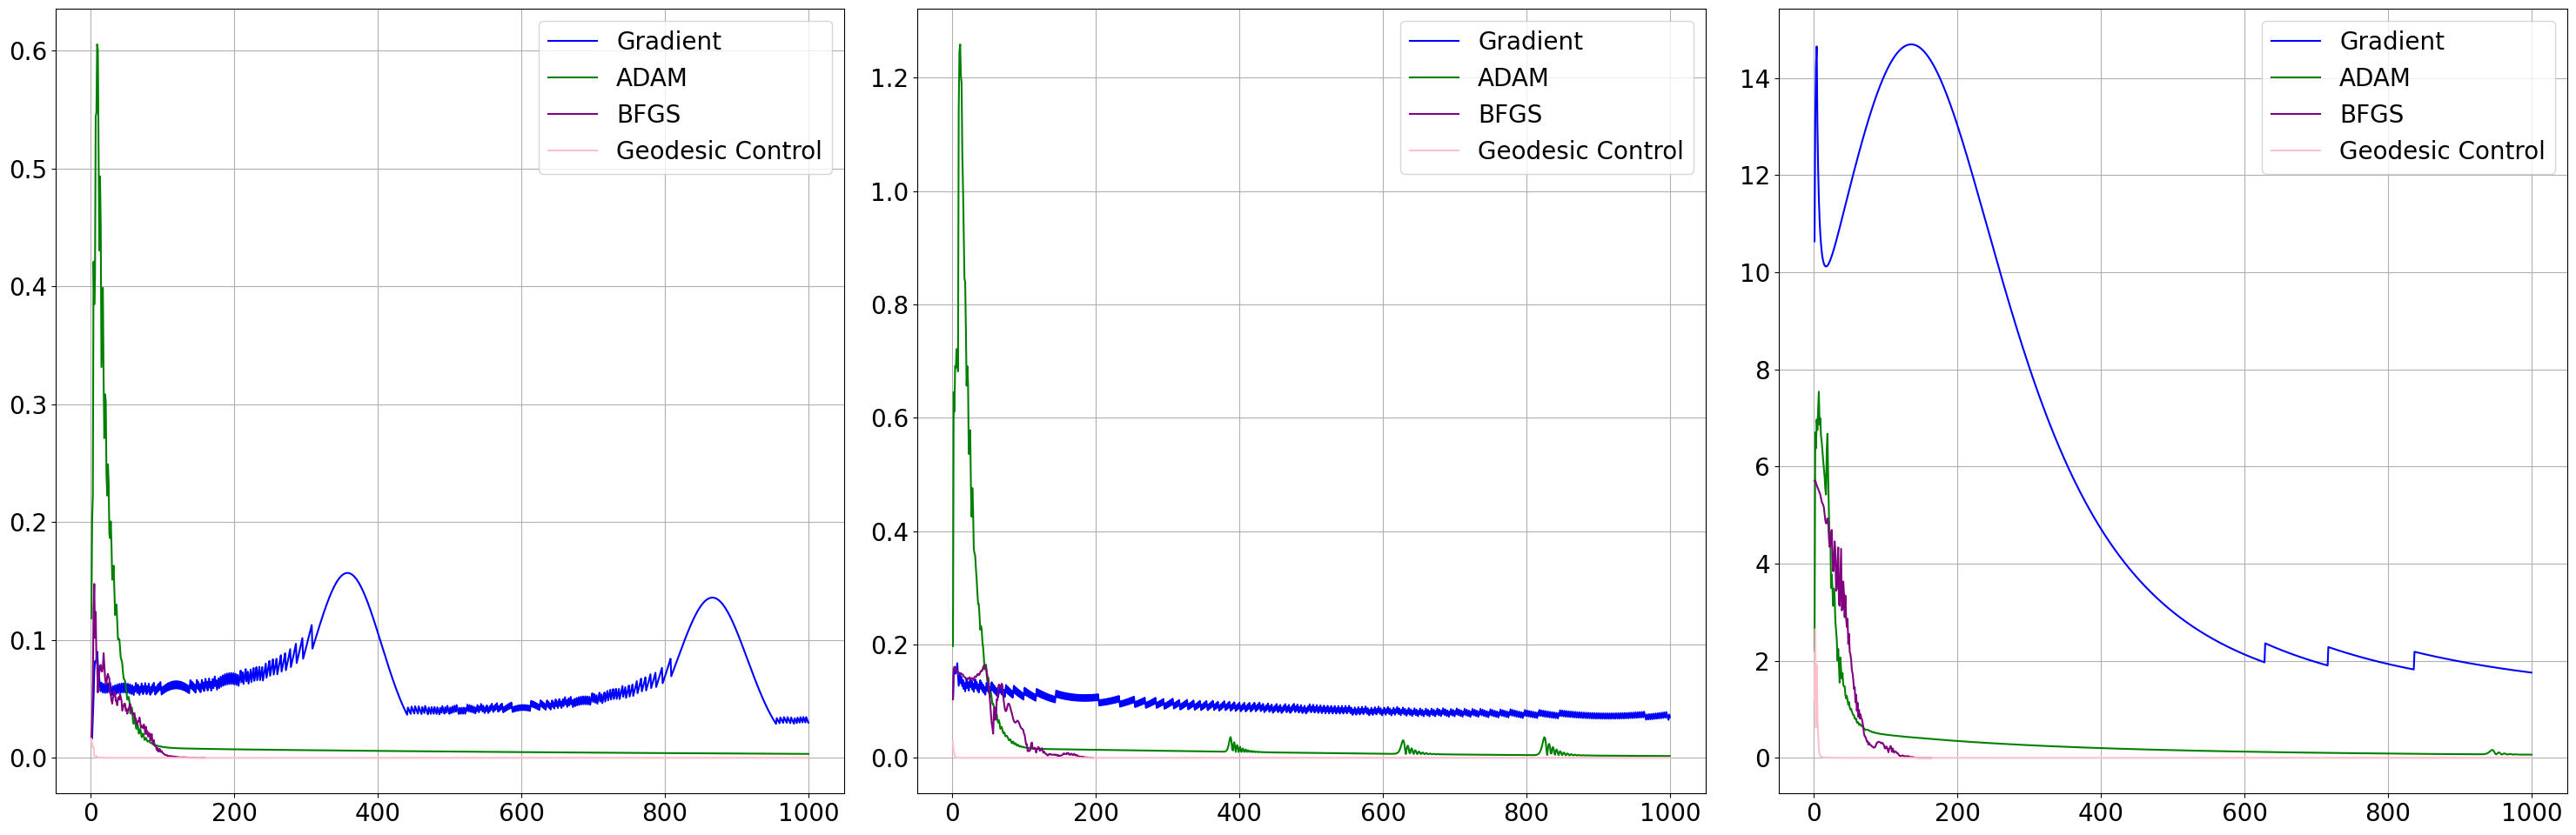

In [119]:
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(131)
ax.plot(jnp.arange(1,len(s2_grad_grad)+1,1), s2_grad_grad, color='blue', alpha=1.0,
       label="Gradient")
ax.plot(jnp.arange(1,len(s2_jax_grad)+1,1), s2_jax_grad, color='green', alpha=1.0,
       label="ADAM")
ax.plot(jnp.arange(1,len(s2_scipy_grad)+1,), s2_scipy_grad, color="purple", alpha=1.0,
       label="BFGS")
ax.plot(jnp.arange(1,len(s2_gc_grad)+1,1), s2_gc_grad, color='pink', alpha=1.0,
       label="Geodesic Control")
ax.grid(True)
ax.legend(loc='upper right')
fig.tight_layout()

ax = fig.add_subplot(132)
ax.plot(jnp.arange(1,len(p_grad_grad)+1,1), p_grad_grad, color='blue', alpha=1.0,
       label="Gradient")
ax.plot(jnp.arange(1,len(p_jax_grad)+1,1), p_jax_grad, color='green', alpha=1.0,
       label="ADAM")
ax.plot(jnp.arange(1,len(p_scipy_grad)+1,), p_scipy_grad, color="purple", alpha=1.0,
       label="BFGS")
ax.plot(jnp.arange(1,len(p_gc_grad)+1,1), p_gc_grad, color='pink', alpha=1.0,
       label="Geodesic Control")
ax.grid(True)
ax.legend(loc='upper right')
fig.tight_layout()

ax = fig.add_subplot(133)
ax.plot(jnp.arange(1,len(hp_grad_grad)+1,1), hp_grad_grad, color='blue', alpha=1.0,
       label="Gradient")
ax.plot(jnp.arange(1,len(hp_jax_grad)+1,1), hp_jax_grad, color='green', alpha=1.0,
       label="ADAM")
ax.plot(jnp.arange(1,len(hp_scipy_grad)+1,), hp_scipy_grad, color="purple", alpha=1.0,
       label="BFGS")
ax.plot(jnp.arange(1,len(hp_gc_grad)+1,1), hp_gc_grad, color='pink', alpha=1.0,
       label="Geodesic Control")
ax.grid(True)
ax.legend(loc='upper right')
fig.tight_layout()

plt.show()



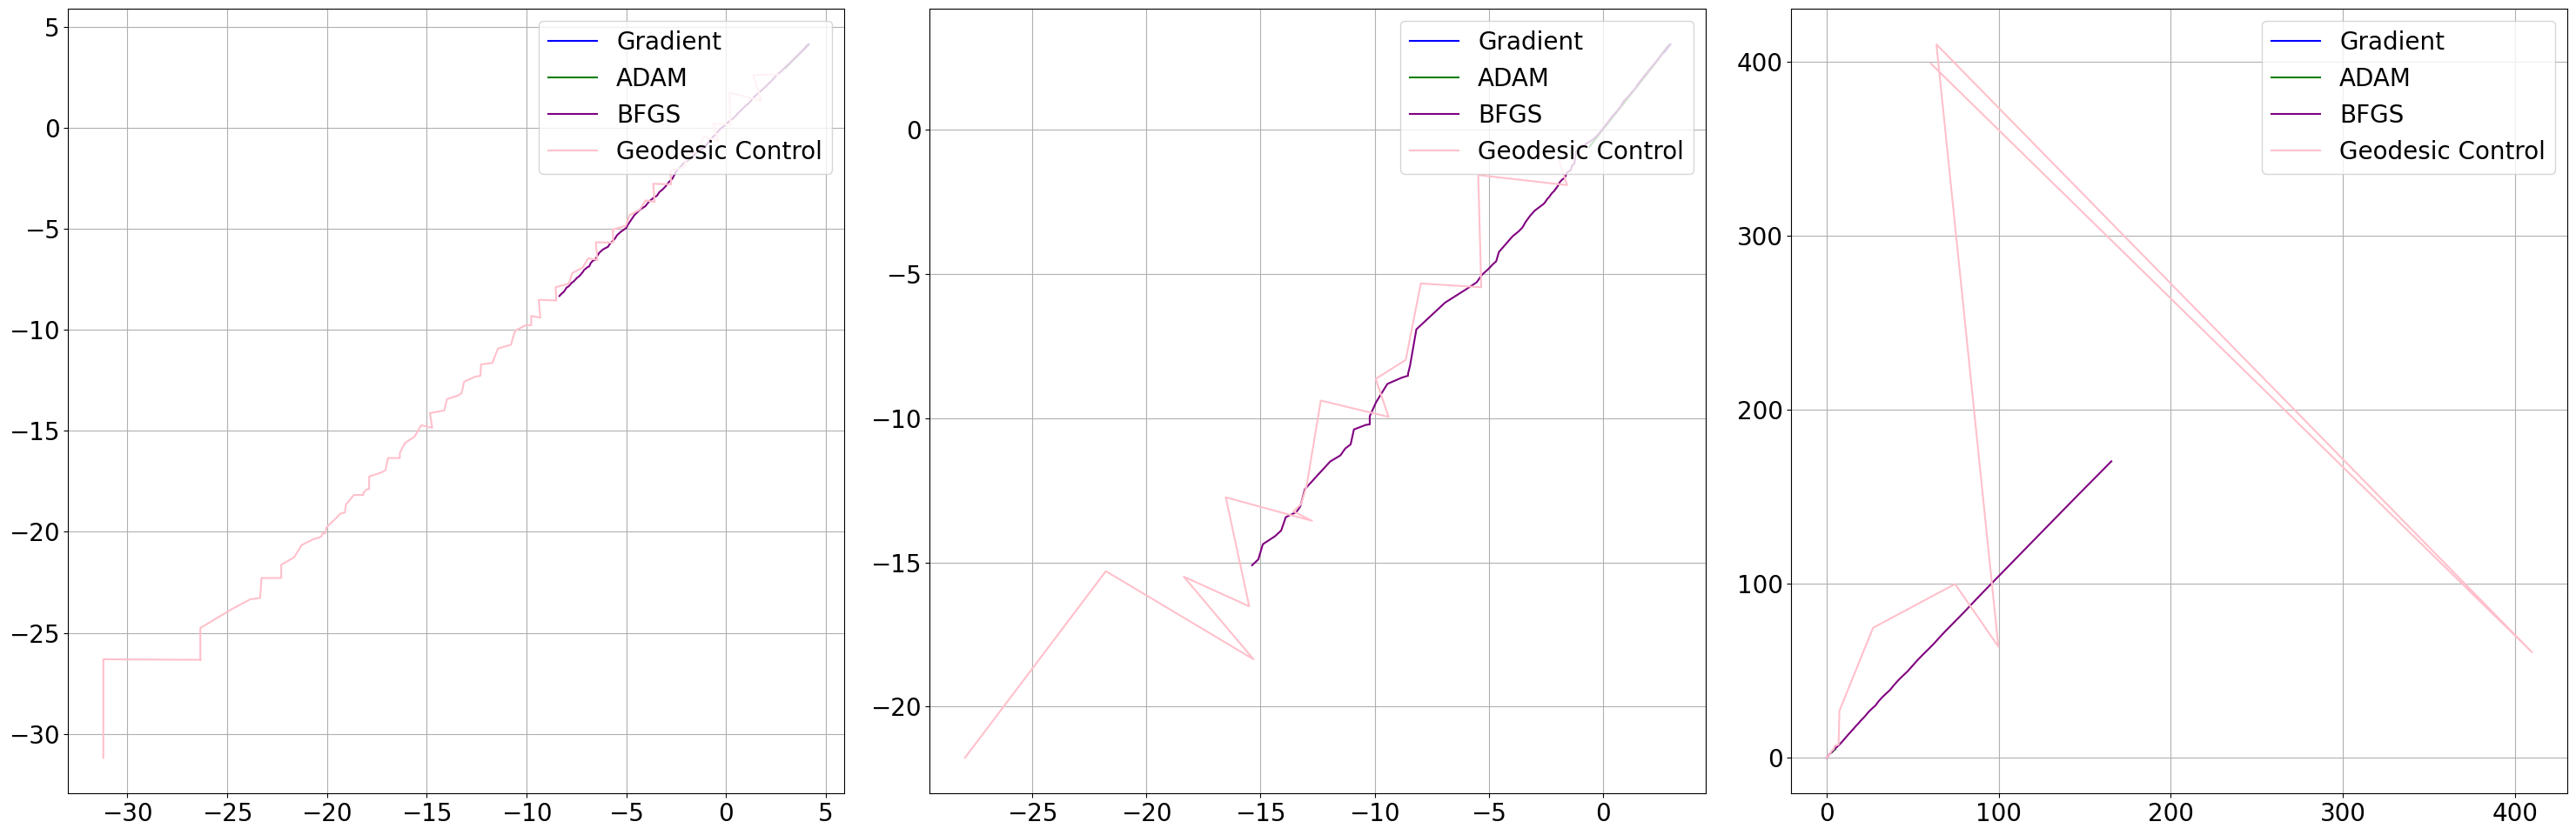

In [120]:
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(131)
ax.plot(jnp.log(s2_grad_error_curve[1:]), jnp.log(s2_grad_error_curve[:-1]), color='blue', alpha=1.0,
       label="Gradient")
ax.plot(jnp.log(s2_jax_error_curve[1:]), jnp.log(s2_jax_error_curve[:-1]), color='green', alpha=1.0,
       label="ADAM")
ax.plot(jnp.log(s2_scipy_error_curve[1:]), jnp.log(s2_scipy_error_curve[:-1]), color="purple", alpha=1.0,
       label="BFGS")
ax.plot(jnp.log(s2_gc_error_curve[1:]), jnp.log(s2_gc_error_curve[:-1]), color='pink', alpha=1.0,
       label="Geodesic Control")
ax.grid(True)
ax.legend(loc='upper right')
fig.tight_layout()

ax = fig.add_subplot(132)
ax.plot(jnp.log(p_grad_error_curve[1:]), jnp.log(p_grad_error_curve[:-1]), color='blue', alpha=1.0,
       label="Gradient")
ax.plot(jnp.log(p_jax_error_curve[1:]), jnp.log(p_jax_error_curve[:-1]), color='green', alpha=1.0,
       label="ADAM")
ax.plot(jnp.log(p_scipy_error_curve[1:]), jnp.log(p_scipy_error_curve[:-1]), color="purple", alpha=1.0,
       label="BFGS")
ax.plot(jnp.log(p_gc_error_curve[1:]), jnp.log(p_gc_error_curve[:-1]), color='pink', alpha=1.0,
       label="Geodesic Control")
ax.grid(True)
ax.legend(loc='upper right')
fig.tight_layout()

ax = fig.add_subplot(133)
ax.plot(jnp.log(hp_grad_error_curve[1:]), jnp.log(hp_grad_error_curve[:-1]), color='blue', alpha=1.0,
       label="Gradient")
ax.plot(jnp.log(hp_jax_error_curve[1:]), jnp.log(hp_jax_error_curve[:-1]), color='green', alpha=1.0,
       label="ADAM")
ax.plot(hp_scipy_error_curve[1:], hp_scipy_error_curve[:-1], color="purple", alpha=1.0,
       label="BFGS")
ax.plot(hp_gc_error_curve[1:], hp_gc_error_curve[:-1], color='pink', alpha=1.0,
       label="Geodesic Control")
ax.grid(True)
ax.legend(loc='upper right')
fig.tight_layout()

plt.show()

